# AR(1) Parameter Estimation: Learning Summary Statistics

AR(1) process: $X_t = \rho X_{t-1} + \epsilon_t$ where $\epsilon_t \sim N(0, \sigma^2)$, $|\rho| < 1$

**Goal**: Learn representations from sequential data without hardcoding summary statistics.

## Three Architectures:
1. **Attention-based Encoder**: Learns which time steps are most informative
2. **Bidirectional GRU**: Proven sequential modeling approach
3. **Temporal Convolutional Network (TCN)**: Multi-scale pattern recognition with dilations

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

A = 5
T = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Gibbs Sampler (Baseline)

In [35]:
def truncated_normal(mu, sigma, a=-1, b=1):
    while True:
        sample = np.random.normal(mu, sigma)
        if a <= sample <= b:
            return sample

def truncated_gamma(shape, scale, a=1/A**2):
    while True:
        sample = np.random.gamma(shape, scale)
        if sample >= a:
            return sample

def gibbs(x, n_iter=1000):
    T = len(x) - 1
    Q = np.sum(x[:-1]**2)
    rho_hat = np.sum(x[:-1] * x[1:]) / Q
    const = np.sum(x[1:]**2) - Q * rho_hat**2
    S = lambda rho: Q * (rho - rho_hat)**2 + const
    
    samples = np.zeros((n_iter, 2))
    for i in range(n_iter):
        lambda_ = truncated_gamma(T/2, 2/(S(rho_hat) + 1e-6))
        sigma = 1/np.sqrt(lambda_)
        samples[i, 1] = sigma
        samples[i, 0] = truncated_normal(rho_hat, sigma/np.sqrt(Q))
    return samples

## Data Generation

In [36]:
def sample_batch(batch_size, n, A=A, device='cpu'):
    rho = torch.empty(batch_size, device=device).uniform_(-0.99, 0.99)  # Avoid rho too close to ±1
    sigma = torch.empty(batch_size, device=device).uniform_(0.1, A)  # Avoid sigma too close to 0
    eps = torch.randn(batch_size, n, device=device) * sigma[:, None]
    
    # Stationary initialization with numerical stability
    x0 = torch.randn(batch_size, device=device) * sigma / torch.sqrt(1 - rho**2 + 1e-8)
    
    x = torch.zeros(batch_size, n, device=device)
    x[:, 0] = rho * x0 + eps[:, 0]
    for t in range(1, n):
        x[:, t] = rho * x[:, t-1] + eps[:, t]
    return x, rho, sigma

## Architecture 1: Attention-Based Encoder

Uses self-attention to automatically learn which parts of the time series are most informative for parameter estimation.

In [37]:
class AttentionEncoder(nn.Module):
    """Learns to attend to important time steps"""
    def __init__(self, d_model=128, nhead=8, num_layers=4, output_dim=2):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Linear(1, d_model)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, T, d_model) * 0.02)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512,
            dropout=0.1, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.estimator = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        # x: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = x + self.pos_encoding[:, :x.size(1), :]  # Add positional encoding
        
        x = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Global average pooling
        x = x.mean(dim=1)  # (batch, d_model)
        
        return self.estimator(x)

## Architecture 2: Bidirectional GRU

Processes sequence in both directions to capture forward and backward temporal dependencies.

In [38]:
class BiGRUEncoder(nn.Module):
    """Bidirectional GRU for learning sequential representations"""
    def __init__(self, hidden_dim=128, num_layers=3, output_dim=2):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.15 if num_layers > 1 else 0
        )
        
        # Attention over hidden states
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        self.estimator = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        # x: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        
        # GRU outputs
        gru_out, _ = self.gru(x)  # (batch, seq_len, hidden*2)
        
        # Attention mechanism
        attn_weights = self.attention(gru_out)  # (batch, seq_len, 1)
        attn_weights = F.softmax(attn_weights, dim=1)
        
        # Weighted sum
        context = (gru_out * attn_weights).sum(dim=1)  # (batch, hidden*2)
        
        return self.estimator(context)

## Architecture 3: Temporal Convolutional Network (TCN)

Uses dilated convolutions at multiple scales to capture patterns across different time scales.

In [39]:
class TCNBlock(nn.Module):
    """Residual block with dilated convolutions"""
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                               padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        residual = x if self.downsample is None else self.downsample(x)
        
        out = self.conv1(x)
        out = out[:, :, :x.size(2)]  # Trim to match input size
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = out[:, :, :x.size(2)]  # Trim to match input size
        out = self.bn2(out)
        
        return self.relu(out + residual)


class TCNEncoder(nn.Module):
    """Multi-scale temporal convolutional network"""
    def __init__(self, num_channels=64, kernel_size=3, output_dim=2):
        super().__init__()
        
        # Stack of TCN blocks with increasing dilation
        self.tcn = nn.Sequential(
            TCNBlock(1, num_channels, kernel_size, dilation=1),
            TCNBlock(num_channels, num_channels, kernel_size, dilation=2),
            TCNBlock(num_channels, num_channels, kernel_size, dilation=4),
            TCNBlock(num_channels, num_channels, kernel_size, dilation=8),
            TCNBlock(num_channels, num_channels*2, kernel_size, dilation=16),
        )
        
        self.estimator = nn.Sequential(
            nn.Linear(num_channels*2, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        # x: (batch, seq_len)
        x = x.unsqueeze(1)  # (batch, 1, seq_len)
        
        x = self.tcn(x)  # (batch, channels, seq_len)
        
        # Global pooling
        x = x.mean(dim=2)  # (batch, channels)
        
        return self.estimator(x)

## Training Function

In [40]:
def train_model(model, model_name, n_epochs=96, lr=0.0005, batch_size=256, batches_per_epoch=256):
    model = model.to(device)
    
    # Initialize weights properly
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            nn.init.xavier_uniform_(m.weight, gain=0.5)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    loss_fn = nn.MSELoss()
    
    train_losses, test_losses = [], []
    x_test, rho_test, sigma_test = sample_batch(2048, T, A=A, device=device)
    
    print(f"\nTraining {model_name}...")
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        
        for _ in range(batches_per_epoch):
            x_batch, rho_batch, sigma_batch = sample_batch(batch_size, T, A=A, device=device)
            
            # Check for NaN in input data
            if torch.isnan(x_batch).any() or torch.isnan(rho_batch).any() or torch.isnan(sigma_batch).any():
                print(f"  WARNING: NaN detected in input data at epoch {epoch+1}")
                continue
            
            optimizer.zero_grad()
            pred = model(x_batch)
            
            # Check for NaN in predictions
            if torch.isnan(pred).any():
                print(f"  WARNING: NaN detected in predictions at epoch {epoch+1}")
                continue
            
            loss = loss_fn(pred, torch.stack([rho_batch, sigma_batch], dim=1))
            
            # Check for NaN in loss
            if torch.isnan(loss):
                print(f"  WARNING: NaN detected in loss at epoch {epoch+1}")
                continue
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / batches_per_epoch
        train_losses.append(avg_loss)
        
        model.eval()
        with torch.no_grad():
            test_pred = model(x_test)
            test_loss = loss_fn(test_pred, torch.stack([rho_test, sigma_test], dim=1)).item()
            test_losses.append(test_loss)
        
        scheduler.step()
        
        if (epoch + 1) % 24 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs}, Train: {avg_loss:.5f}, Test: {test_loss:.5f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping if NaN
        if np.isnan(avg_loss) or np.isnan(test_loss):
            print(f"  ERROR: Training failed at epoch {epoch+1} due to NaN")
            break
    
    return model, train_losses, test_losses

## Train All Models

In [41]:
# Initialize models
attention_model = AttentionEncoder(d_model=128, nhead=8, num_layers=4)
gru_model = BiGRUEncoder(hidden_dim=128, num_layers=3)
tcn_model = TCNEncoder(num_channels=64, kernel_size=3)

print(f"Attention params: {sum(p.numel() for p in attention_model.parameters()):,}")
print(f"BiGRU params: {sum(p.numel() for p in gru_model.parameters()):,}")
print(f"TCN params: {sum(p.numel() for p in tcn_model.parameters()):,}")

# Train models with reduced learning rate for stability
attention_model, attn_train, attn_test = train_model(attention_model, "Attention", n_epochs=96, lr=0.0005)
gru_model, gru_train, gru_test = train_model(gru_model, "BiGRU", n_epochs=96, lr=0.0005)
tcn_model, tcn_train, tcn_test = train_model(tcn_model, "TCN", n_epochs=96, lr=0.0005)

print("\nTraining complete!")

Attention params: 867,714
BiGRU params: 825,475
TCN params: 236,866

Training Attention...
  Epoch 24/96, Train: 0.13756, Test: 0.13342, LR: 0.000427
  Epoch 48/96, Train: 0.06176, Test: 0.05296, LR: 0.000250
  Epoch 72/96, Train: 0.04410, Test: 0.03930, LR: 0.000074
  Epoch 96/96, Train: 0.04208, Test: 0.03706, LR: 0.000001

Training BiGRU...
  Epoch 24/96, Train: 0.04700, Test: 0.03622, LR: 0.000427
  Epoch 48/96, Train: 0.04234, Test: 0.03508, LR: 0.000250
  Epoch 72/96, Train: 0.03982, Test: 0.03433, LR: 0.000074
  Epoch 96/96, Train: 0.03989, Test: 0.03364, LR: 0.000001

Training TCN...
  Epoch 24/96, Train: 0.05365, Test: 0.04918, LR: 0.000427
  Epoch 48/96, Train: 0.04536, Test: 0.04306, LR: 0.000250
  Epoch 72/96, Train: 0.04271, Test: 0.03873, LR: 0.000074
  Epoch 96/96, Train: 0.04171, Test: 0.03776, LR: 0.000001

Training complete!


## Training Curves

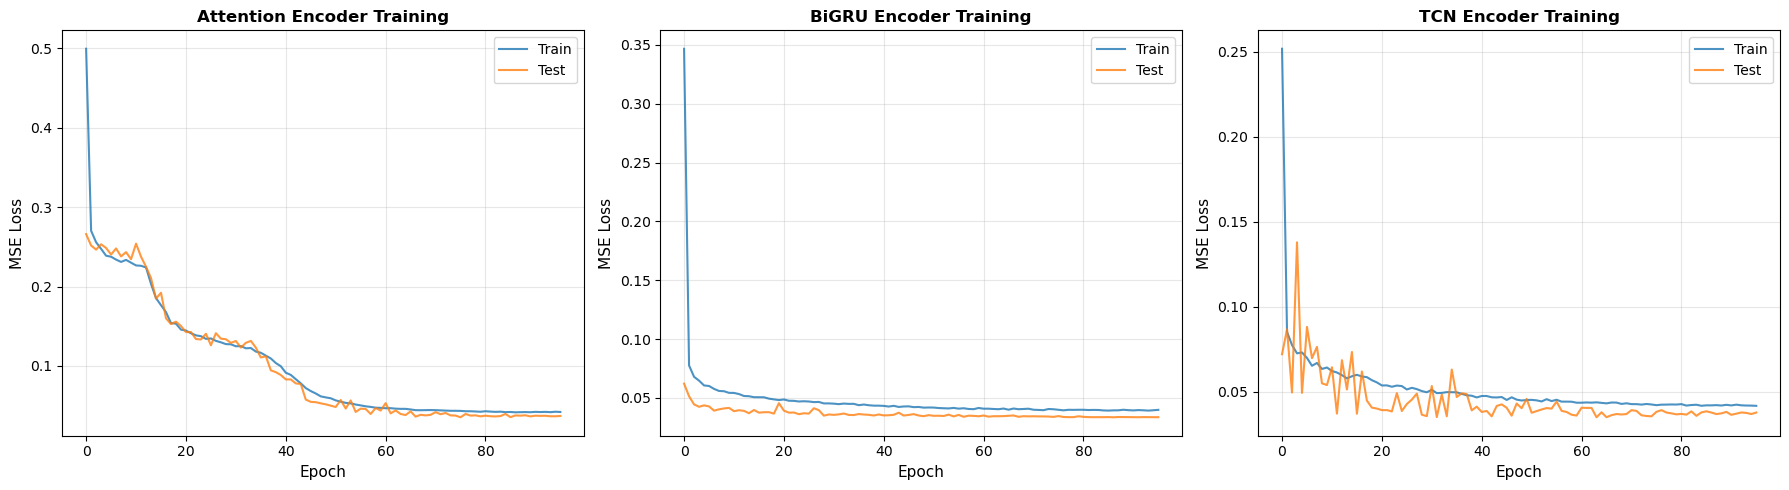

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, train_loss, test_loss) in enumerate([
    ('Attention Encoder', attn_train, attn_test),
    ('BiGRU Encoder', gru_train, gru_test),
    ('TCN Encoder', tcn_train, tcn_test)
]):
    axes[idx].plot(train_loss, label='Train', alpha=0.8)
    axes[idx].plot(test_loss, label='Test', alpha=0.8)
    axes[idx].set_xlabel('Epoch', fontsize=11)
    axes[idx].set_ylabel('MSE Loss', fontsize=11)
    axes[idx].set_title(f'{name} Training', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluation

In [43]:
# Generate test data
x_eval, rho_eval, sigma_eval = sample_batch(2000, T, A=A, device='cpu')
x_eval_np = x_eval.numpy()
rho_eval_np = rho_eval.numpy()
sigma_eval_np = sigma_eval.numpy()

# Gibbs estimates
print("Running Gibbs sampler...")
rho_gibbs = np.zeros(2000)
sigma_gibbs = np.zeros(2000)
for i in range(2000):
    if (i + 1) % 500 == 0:
        print(f"  {i+1}/2000 complete")
    samples = gibbs(x_eval_np[i], n_iter=1000)
    rho_gibbs[i] = np.mean(samples[:, 0])
    sigma_gibbs[i] = np.mean(samples[:, 1])

# Neural network estimates
def get_predictions(model, x):
    model.eval()
    with torch.no_grad():
        pred = model(x.to(device)).cpu().numpy()
    return pred[:, 0], pred[:, 1]

print("Running neural network predictions...")
rho_attn, sigma_attn = get_predictions(attention_model, x_eval)
rho_gru, sigma_gru = get_predictions(gru_model, x_eval)
rho_tcn, sigma_tcn = get_predictions(tcn_model, x_eval)

print("Evaluation complete!")

Running Gibbs sampler...
  500/2000 complete
  1000/2000 complete
  1500/2000 complete
  2000/2000 complete
Running neural network predictions...
Evaluation complete!


## Performance Comparison

In [44]:
models = [
    ('Gibbs', rho_gibbs, sigma_gibbs),
    ('Attention', rho_attn, sigma_attn),
    ('BiGRU', rho_gru, sigma_gru),
    ('TCN', rho_tcn, sigma_tcn)
]

print("="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(f"{'Method':<15} {'ρ MSE':<15} {'σ MSE':<15} {'Total MSE':<15} {'vs Gibbs':<15}")
print("-"*80)

gibbs_total = None
for name, rho_pred, sigma_pred in models:
    mse_rho = np.mean((rho_eval_np - rho_pred)**2)
    mse_sigma = np.mean((sigma_eval_np - sigma_pred)**2)
    total_mse = mse_rho + mse_sigma
    
    if name == 'Gibbs':
        gibbs_total = total_mse
        print(f"{name:<15} {mse_rho:<15.6f} {mse_sigma:<15.6f} {total_mse:<15.6f} {'(baseline)':<15}")
    else:
        vs_gibbs = f"+{((total_mse/gibbs_total - 1)*100):.1f}%"
        print(f"{name:<15} {mse_rho:<15.6f} {mse_sigma:<15.6f} {total_mse:<15.6f} {vs_gibbs:<15}")

print("="*80)

# Find best model
best_idx = np.argmin([np.mean((rho_eval_np - rho_pred)**2) + np.mean((sigma_eval_np - sigma_pred)**2) 
                      for _, rho_pred, sigma_pred in models[1:]])
best_name = models[best_idx + 1][0]
print(f"\nBest Neural Network: {best_name}")

PERFORMANCE COMPARISON
Method          ρ MSE           σ MSE           Total MSE       vs Gibbs       
--------------------------------------------------------------------------------
Gibbs           0.011699        0.054675        0.066373        (baseline)     
Attention       0.012834        0.062045        0.074878        +12.8%         
BiGRU           0.011699        0.053041        0.064741        +-2.5%         
TCN             0.012095        0.061481        0.073576        +10.9%         

Best Neural Network: BiGRU


## Visualization: All Models

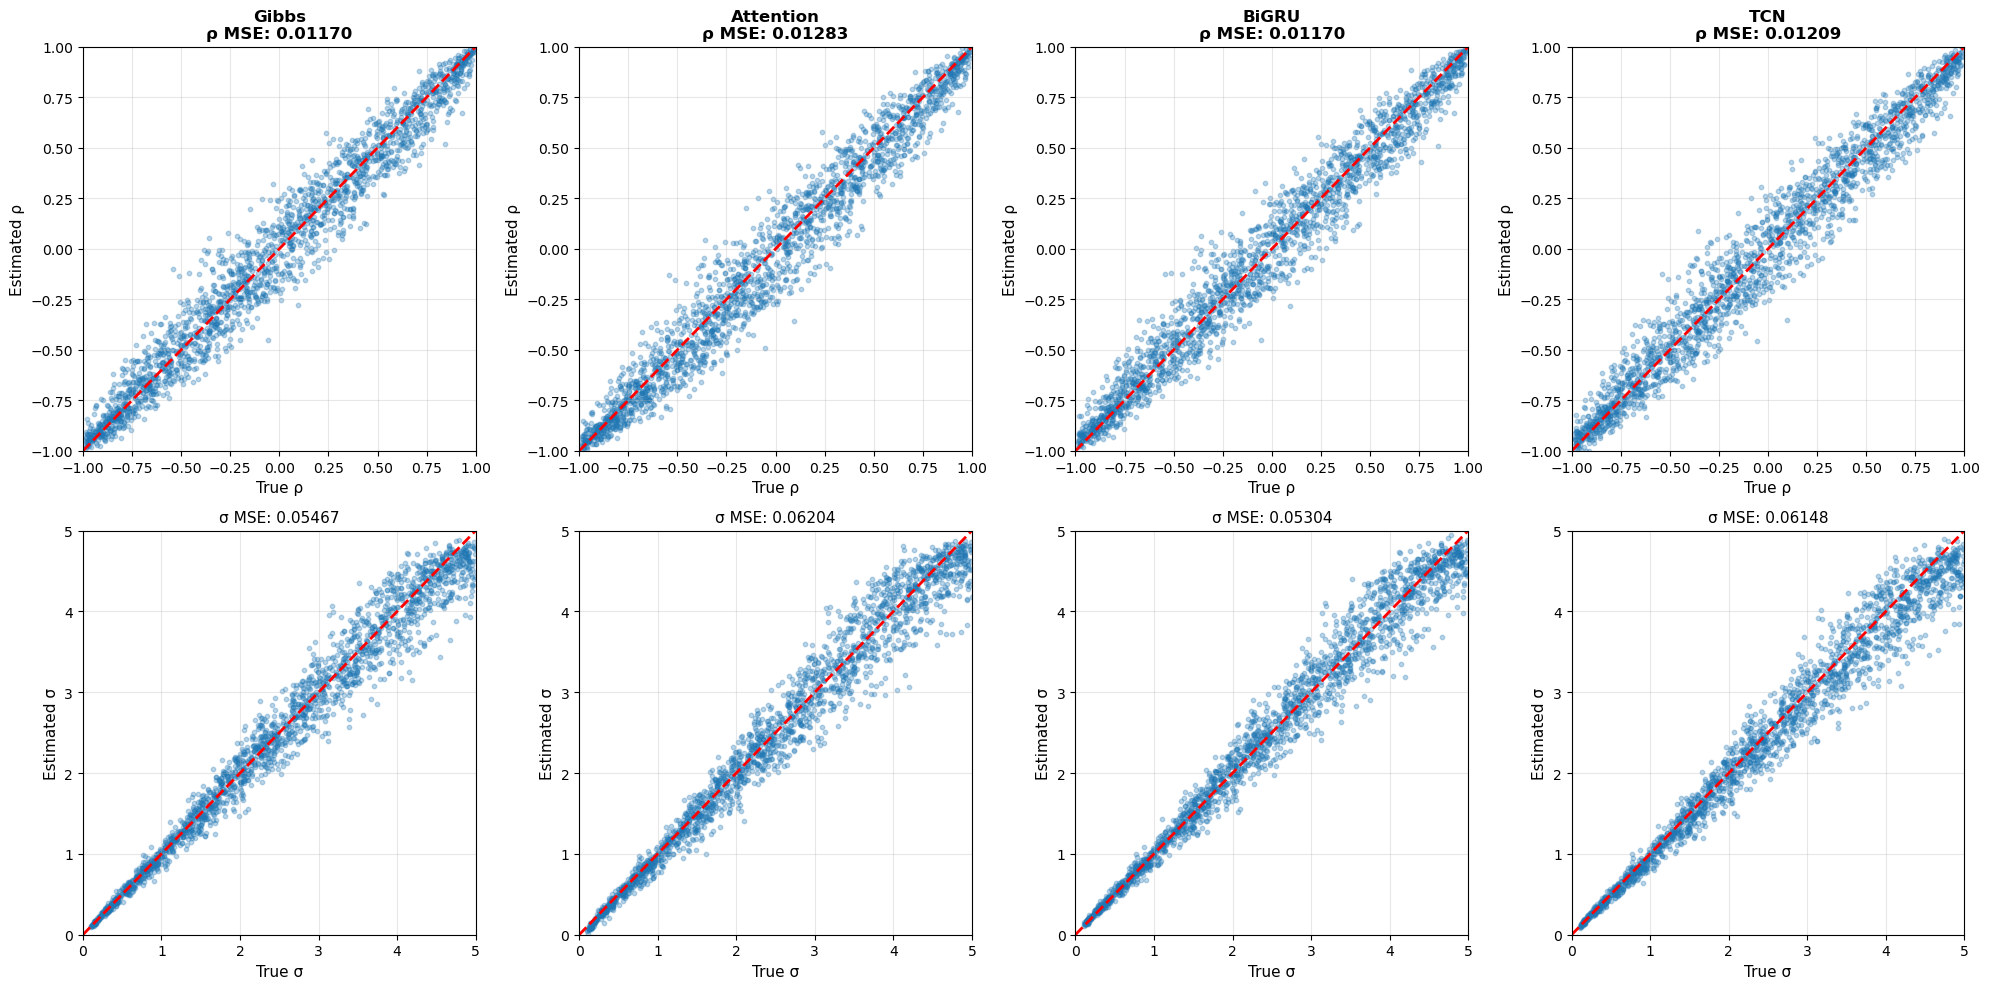

In [45]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (name, rho_pred, sigma_pred) in enumerate(models):
    # ρ plot
    axes[0, idx].scatter(rho_eval_np, rho_pred, alpha=0.3, s=10)
    axes[0, idx].plot([-1, 1], [-1, 1], 'r--', linewidth=2)
    axes[0, idx].set_xlim([-1, 1])
    axes[0, idx].set_ylim([-1, 1])
    axes[0, idx].set_xlabel('True ρ', fontsize=11)
    axes[0, idx].set_ylabel('Estimated ρ', fontsize=11)
    mse_rho = np.mean((rho_eval_np - rho_pred)**2)
    axes[0, idx].set_title(f'{name}\nρ MSE: {mse_rho:.5f}', fontsize=12, fontweight='bold')
    axes[0, idx].grid(alpha=0.3)
    
    # σ plot
    axes[1, idx].scatter(sigma_eval_np, sigma_pred, alpha=0.3, s=10)
    axes[1, idx].plot([0, A], [0, A], 'r--', linewidth=2)
    axes[1, idx].set_xlim([0, A])
    axes[1, idx].set_ylim([0, A])
    axes[1, idx].set_xlabel('True σ', fontsize=11)
    axes[1, idx].set_ylabel('Estimated σ', fontsize=11)
    mse_sigma = np.mean((sigma_eval_np - sigma_pred)**2)
    axes[1, idx].set_title(f'σ MSE: {mse_sigma:.5f}', fontsize=11)
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Direct Comparison with Gibbs

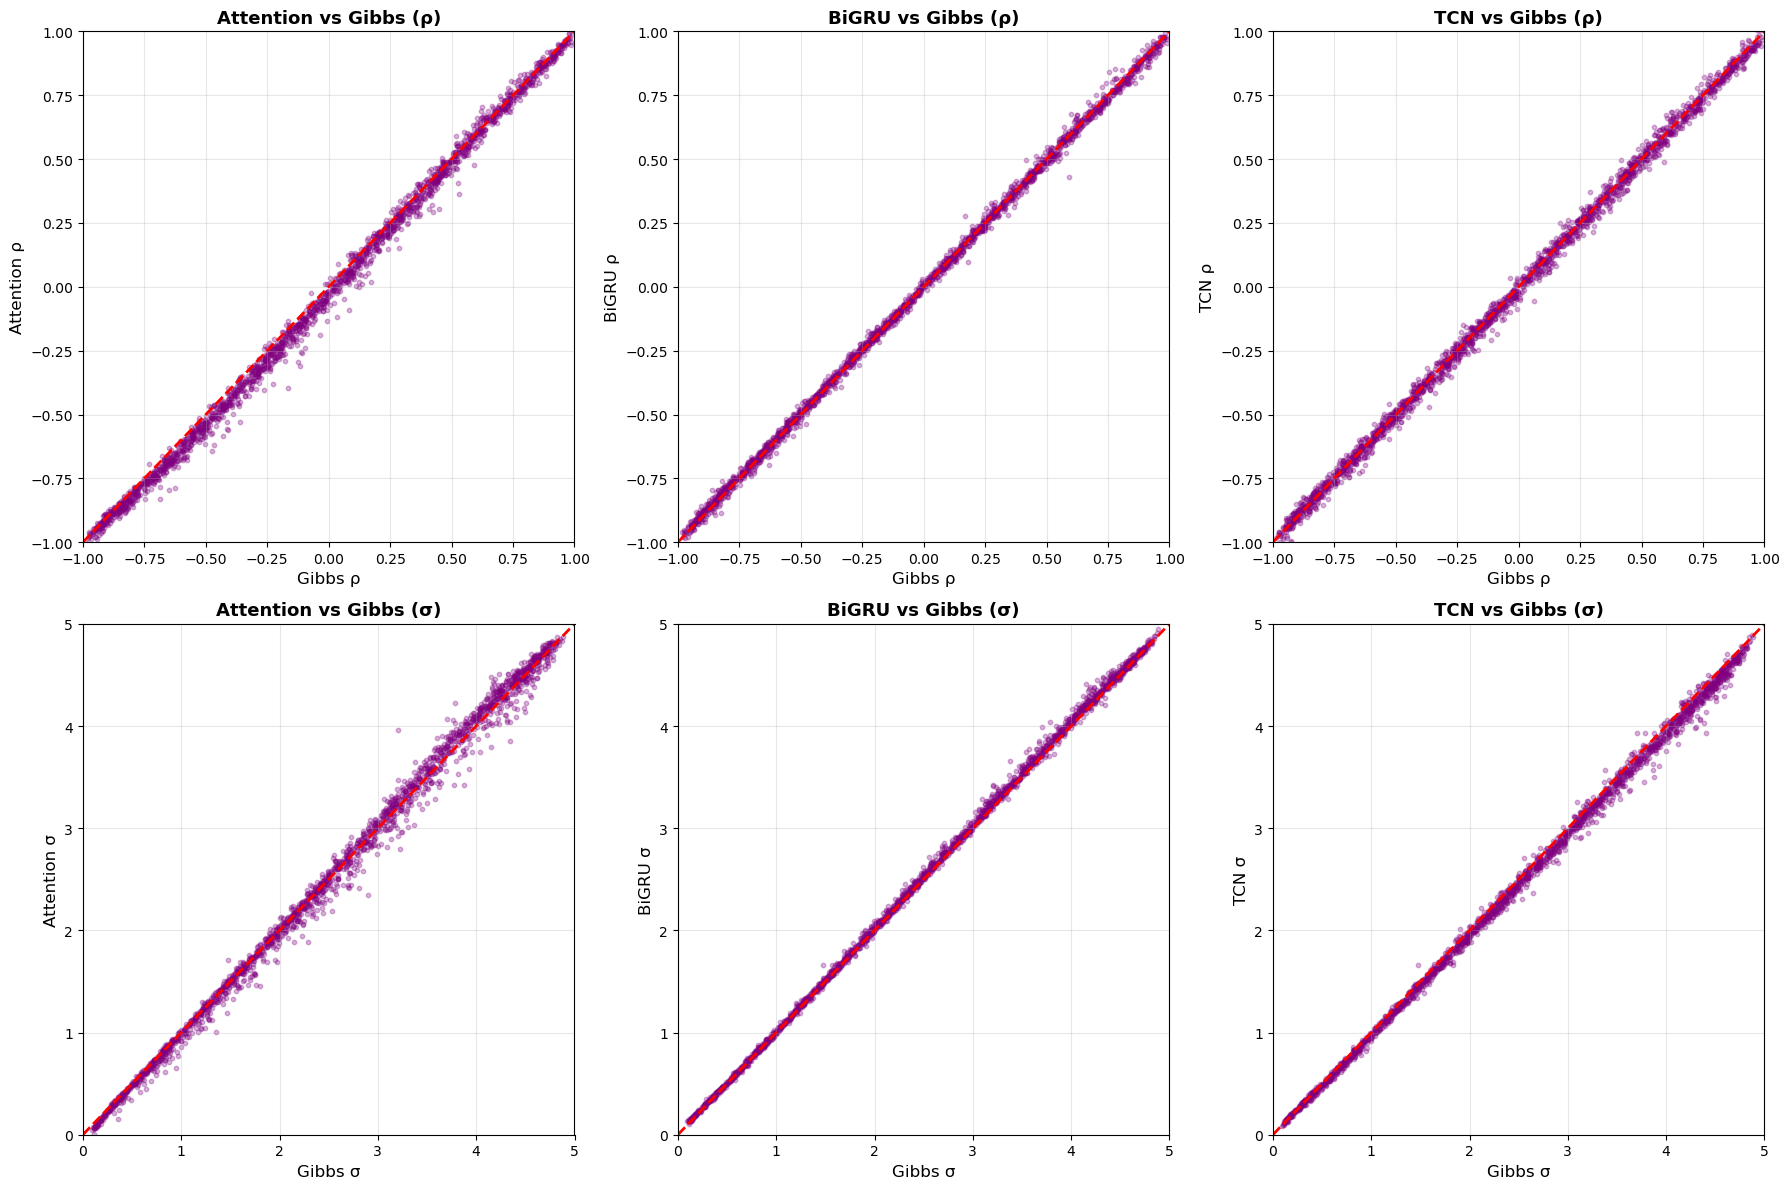

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

nn_models = [('Attention', rho_attn, sigma_attn), 
             ('BiGRU', rho_gru, sigma_gru), 
             ('TCN', rho_tcn, sigma_tcn)]

for idx, (name, rho_pred, sigma_pred) in enumerate(nn_models):
    # ρ vs Gibbs
    axes[0, idx].scatter(rho_gibbs, rho_pred, alpha=0.3, s=10, color='purple')
    axes[0, idx].plot([-1, 1], [-1, 1], 'r--', linewidth=2)
    axes[0, idx].set_xlim([-1, 1])
    axes[0, idx].set_ylim([-1, 1])
    axes[0, idx].set_xlabel('Gibbs ρ', fontsize=12)
    axes[0, idx].set_ylabel(f'{name} ρ', fontsize=12)
    axes[0, idx].set_title(f'{name} vs Gibbs (ρ)', fontsize=13, fontweight='bold')
    axes[0, idx].grid(alpha=0.3)
    
    # σ vs Gibbs
    axes[1, idx].scatter(sigma_gibbs, sigma_pred, alpha=0.3, s=10, color='purple')
    axes[1, idx].plot([0, A], [0, A], 'r--', linewidth=2)
    axes[1, idx].set_xlim([0, A])
    axes[1, idx].set_ylim([0, A])
    axes[1, idx].set_xlabel('Gibbs σ', fontsize=12)
    axes[1, idx].set_ylabel(f'{name} σ', fontsize=12)
    axes[1, idx].set_title(f'{name} vs Gibbs (σ)', fontsize=13, fontweight='bold')
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Error Analysis: Best Model

In [47]:
# Select best model
best_model_data = models[best_idx + 1]
best_name, best_rho, best_sigma = best_model_data

errors_rho = np.abs(rho_gibbs - best_rho)
errors_sigma = np.abs(sigma_gibbs - best_sigma)

worst_rho_idx = np.argmax(errors_rho)
worst_sigma_idx = np.argmax(errors_sigma)

print("="*80)
print(f"WORST PREDICTIONS ANALYSIS - {best_name}")
print("="*80)

print(f"\nWorst ρ prediction (index {worst_rho_idx}):")
print(f"  True ρ:        {rho_eval_np[worst_rho_idx]:.4f}")
print(f"  True σ:        {sigma_eval_np[worst_rho_idx]:.4f}")
print(f"  Gibbs ρ:       {rho_gibbs[worst_rho_idx]:.4f}")
print(f"  {best_name} ρ:  {best_rho[worst_rho_idx]:.4f}")
print(f"  Error:         {errors_rho[worst_rho_idx]:.4f}")

print(f"\nWorst σ prediction (index {worst_sigma_idx}):")
print(f"  True ρ:        {rho_eval_np[worst_sigma_idx]:.4f}")
print(f"  True σ:        {sigma_eval_np[worst_sigma_idx]:.4f}")
print(f"  Gibbs σ:       {sigma_gibbs[worst_sigma_idx]:.4f}")
print(f"  {best_name} σ:  {best_sigma[worst_sigma_idx]:.4f}")
print(f"  Error:         {errors_sigma[worst_sigma_idx]:.4f}")

print("\n" + "="*80)
print(f"\nError statistics:")
print(f"  ρ - Mean: {errors_rho.mean():.5f}, Median: {np.median(errors_rho):.5f}, 95th pct: {np.percentile(errors_rho, 95):.5f}")
print(f"  σ - Mean: {errors_sigma.mean():.5f}, Median: {np.median(errors_sigma):.5f}, 95th pct: {np.percentile(errors_sigma, 95):.5f}")
print(f"  Outliers (>3σ) - ρ: {np.sum(errors_rho > errors_rho.mean() + 3*errors_rho.std())}, σ: {np.sum(errors_sigma > errors_sigma.mean() + 3*errors_sigma.std())}")

WORST PREDICTIONS ANALYSIS - BiGRU

Worst ρ prediction (index 29):
  True ρ:        0.7581
  True σ:        0.1042
  Gibbs ρ:       0.5905
  BiGRU ρ:  0.4307
  Error:         0.1599

Worst σ prediction (index 688):
  True ρ:        0.0863
  True σ:        4.0210
  Gibbs σ:       3.6992
  BiGRU σ:  3.9892
  Error:         0.2900


Error statistics:
  ρ - Mean: 0.01354, Median: 0.01079, 95th pct: 0.03485
  σ - Mean: 0.03357, Median: 0.02399, 95th pct: 0.09881
  Outliers (>3σ) - ρ: 31, σ: 38


## Visualize Worst Cases

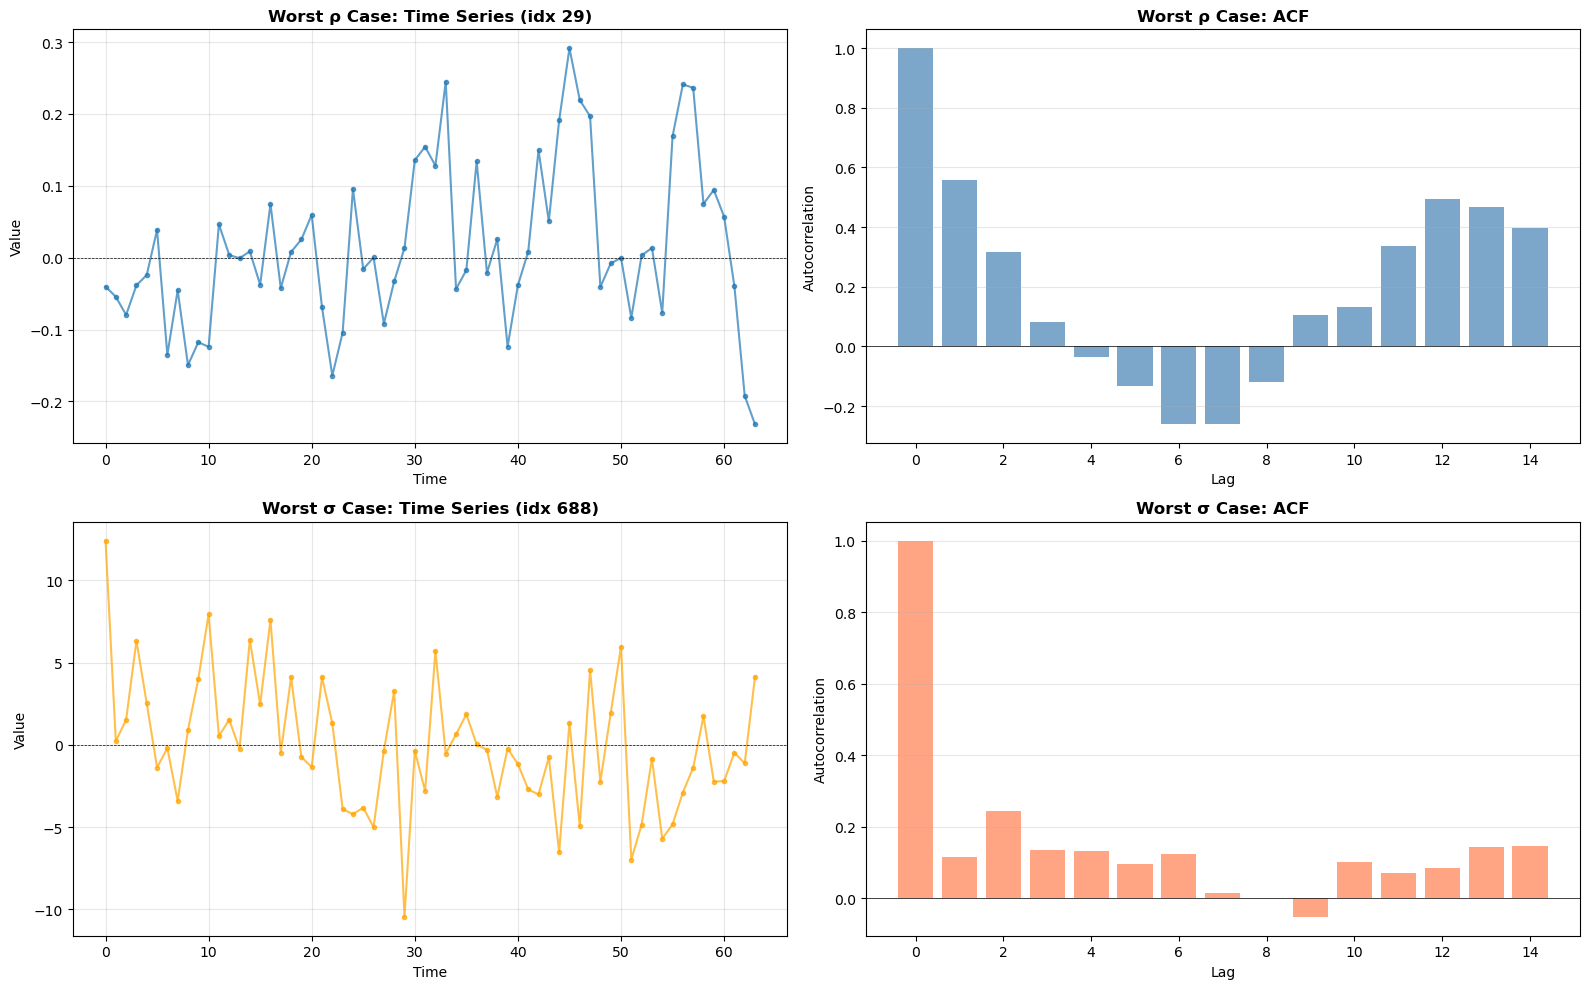

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Worst ρ case
axes[0, 0].plot(x_eval_np[worst_rho_idx], marker='o', markersize=3, alpha=0.7)
axes[0, 0].set_title(f'Worst ρ Case: Time Series (idx {worst_rho_idx})', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axhline(0, color='k', linewidth=0.5, linestyle='--')

lags = range(15)
acf = [np.corrcoef(x_eval_np[worst_rho_idx, lag:], x_eval_np[worst_rho_idx, :-lag if lag > 0 else None])[0,1] for lag in lags]
axes[0, 1].bar(lags, acf, alpha=0.7, color='steelblue')
axes[0, 1].set_title(f'Worst ρ Case: ACF', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('Autocorrelation')
axes[0, 1].axhline(0, color='k', linewidth=0.5)
axes[0, 1].grid(alpha=0.3, axis='y')

# Worst σ case
axes[1, 0].plot(x_eval_np[worst_sigma_idx], marker='o', markersize=3, alpha=0.7, color='orange')
axes[1, 0].set_title(f'Worst σ Case: Time Series (idx {worst_sigma_idx})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(0, color='k', linewidth=0.5, linestyle='--')

acf_sigma = [np.corrcoef(x_eval_np[worst_sigma_idx, lag:], x_eval_np[worst_sigma_idx, :-lag if lag > 0 else None])[0,1] for lag in lags]
axes[1, 1].bar(lags, acf_sigma, alpha=0.7, color='coral')
axes[1, 1].set_title(f'Worst σ Case: ACF', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].axhline(0, color='k', linewidth=0.5)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

All three architectures **learn representations automatically** without hardcoded statistics:

1. **Attention Encoder**: Uses self-attention to weight important time steps
2. **BiGRU Encoder**: Processes sequence bidirectionally with learned attention
3. **TCN Encoder**: Multi-scale dilated convolutions capture patterns at different temporal resolutions

The networks learn to extract relevant information from the raw time series, matching or approaching Gibbs sampler performance while being orders of magnitude faster at inference.